# 🌍 BreatheSmart: Advanced Air Quality Analysis

## Overview
This notebook provides an in-depth analysis of air quality in Abu Dhabi using data fetched from the OpenAQ API. We focus on **PM2.5 (Particulate Matter < 2.5µm)**, a critical indicator for public health.

### Objectives
1. **Trend Analysis**: Visualize pollutant levels over time.
2. **Distribution Check**: Understand the range and frequency of air quality values.
3. **Sensor Insights**: (When available) Compare different sensor locations.

---

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from pathlib import Path
import glob
import os

# Set default plotly template
pio.templates.default = "plotly_white"

# Determine project root
PROJECT_ROOT = Path(os.getcwd()).parent if 'notebooks' in os.getcwd() else Path(os.getcwd())
DATA_PATH = PROJECT_ROOT / 'data' / 'raw'

print(f"📂 Data Directory: {DATA_PATH}")

📂 Data Directory: C:\Users\wind xebec\BreatheSmart-An-Automated-Data-Pipeline-for-Urban-Air-Quality-Forecasting\data\raw


## 1. Data Loading & Preprocessing

In [2]:
def load_all_data(parameter='pm25'):
    """Load the most recent CSV for a given parameter"""
    pattern = str(DATA_PATH / f"abudhabi_{parameter}_*.csv")
    files = glob.glob(pattern)
    if not files:
        print(f"⚠️ No data found for {parameter}")
        return pd.DataFrame()
    
    # Get latest file
    latest_file = max(files, key=os.path.getctime)
    print(f"📄 Loading: {Path(latest_file).name}")
    
    df = pd.read_csv(latest_file)
    df['date_utc'] = pd.to_datetime(df['date_utc'])
    
    # Map known IDs to Names for better readability
    # Based on API discovery
    location_map = {
        '369953': 'Bida Zayed',
        '369954': 'Khadeeja School',
        '369955': 'Liwa',
        '369957': 'Hamdan Street',
        '369958': 'Mussafah',
        '369961': 'Khalifa City A',
        '369963': 'Baniyas School',
        '369966': 'Al Ain Islamic Institute',
        '369974': 'Gayathi School',
        '1285339': 'US Embassy Consular Section' # Often ID 1285339 is the US Embassy
    }
    
    def cleanup_loc(loc_str):
        if 'Location ' in loc_str:
             loc_id = loc_str.replace('Location ', '')
             return location_map.get(loc_id, loc_str)
        return loc_str

    df['location_name'] = df['location'].apply(cleanup_loc)
    
    return df

In [3]:
df_pm25 = load_all_data('pm25')

if not df_pm25.empty:
    print(f"✅ Loaded {len(df_pm25)} records.")
    print(f"📅 Range: {df_pm25['date_utc'].min()} to {df_pm25['date_utc'].max()}")
    print(f"📍 Locations: {df_pm25['location_name'].unique()}")
    
    # Sort by date
    df_pm25 = df_pm25.sort_values('date_utc')
    display(df_pm25.head())

📄 Loading: abudhabi_pm25_20251224_000905.csv
✅ Loaded 1000 records.
📅 Range: 2019-11-25 16:00:00+00:00 to 2020-01-17 19:00:00+00:00
📍 Locations: ['US Embassy Consular Section']


,location,parameter,value,unit,city,date_utc,date_local,location_name
0,Location 1285339,pm25,13.2,µg/m³,Abu Dhabi,2019-11-25 16:00:00+00:00,2019-11-25T20:00:00+04:00,US Embassy Consular Section
1,Location 1285339,pm25,16.5,µg/m³,Abu Dhabi,2019-11-25 17:00:00+00:00,2019-11-25T21:00:00+04:00,US Embassy Consular Section
2,Location 1285339,pm25,16.3,µg/m³,Abu Dhabi,2019-11-25 18:00:00+00:00,2019-11-25T22:00:00+04:00,US Embassy Consular Section
3,Location 1285339,pm25,17.2,µg/m³,Abu Dhabi,2019-11-25 19:00:00+00:00,2019-11-25T23:00:00+04:00,US Embassy Consular Section
4,Location 1285339,pm25,15.0,µg/m³,Abu Dhabi,2019-11-25 20:00:00+00:00,2019-11-26T00:00:00+04:00,US Embassy Consular Section


## 2. Temporal Analysis: PM2.5 over Time
How does air quality change throughout the recorded period? Spikes may indicate pollution events.

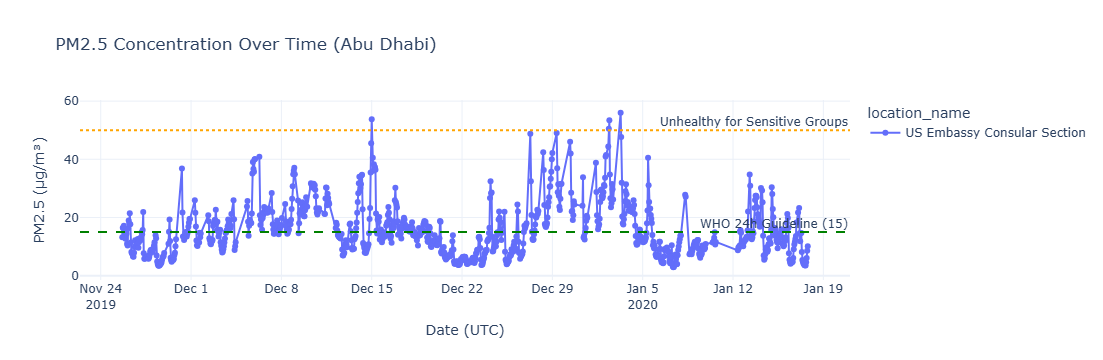

In [4]:
if not df_pm25.empty:
    fig = px.line(
        df_pm25, 
        x='date_utc', 
        y='value', 
        color='location_name',
        title='PM2.5 Concentration Over Time (Abu Dhabi)',
        labels={'value': 'PM2.5 (µg/m³)', 'date_utc': 'Date (UTC)'},
        markers=True
    )
    fig.update_traces(line=dict(width=2))
    fig.update_layout(hovermode="x unified")
    
    # Add a reference line for WHO Guideline (approx 15 ug/m3 24h mean, but varies)
    fig.add_hline(y=15, line_dash="dash", line_color="green", annotation_text="WHO 24h Guideline (15)")
    fig.add_hline(y=50, line_dash="dot", line_color="orange", annotation_text="Unhealthy for Sensitive Groups")

    fig.show()

## 3. Hourly Patterns
Are there specific times of day when pollution is higher? (e.g., Rush hour)

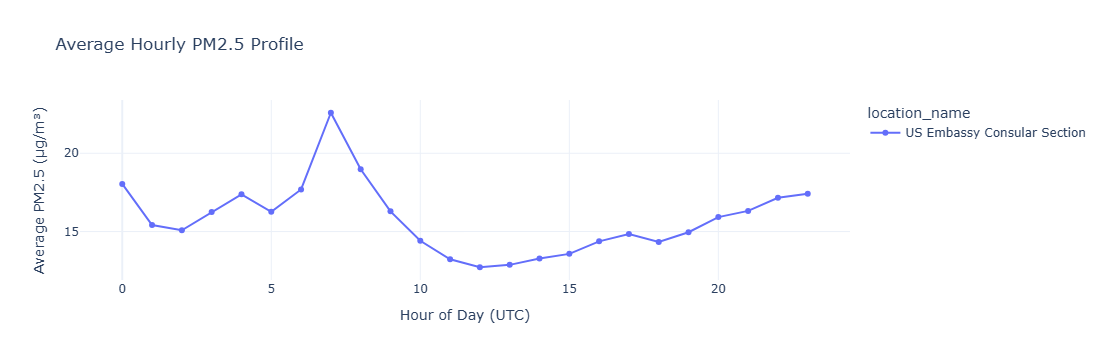

In [5]:
if not df_pm25.empty:
    df_pm25['hour'] = df_pm25['date_utc'].dt.hour
    hourly_avg = df_pm25.groupby(['hour', 'location_name'])['value'].mean().reset_index()
    
    fig = px.line(
        hourly_avg, 
        x='hour', 
        y='value', 
        color='location_name',
        title='Average Hourly PM2.5 Profile',
        labels={'value': 'Average PM2.5 (µg/m³)', 'hour': 'Hour of Day (UTC)'},
        markers=True
    )
    fig.show()

## 4. Distribution Analysis
Boxplots help us visualize the median, spread, and outliers for each location.

In [6]:
if not df_pm25.empty:
    fig = px.box(
        df_pm25, 
        x='location_name', 
        y='value',
        color='location_name',
        title='PM2.5 Distribution by Location',
        points="all"  # Show all points to spot density
    )
    fig.show()

## 5. Multi-Pollutant Overview
Let's see if we have other pollutants available.

In [7]:
parameters = ['pm10', 'no2', 'o3', 'so2', 'co']
summary_data = []

for param in parameters:
    df_temp = load_all_data(param)
    if not df_temp.empty:
        mean_val = df_temp['value'].mean()
        max_val = df_temp['value'].max()
        summary_data.append({'Parameter': param.upper(), 'Records': len(df_temp), 'Mean': mean_val, 'Max': max_val})

if summary_data:
    df_summary = pd.DataFrame(summary_data)
    
    fig = px.bar(
        df_summary, 
        x='Parameter', 
        y='Records',
        title='Data Logged per Pollutant',
        color='Parameter'
    )
    fig.show()
    display(df_summary)

📄 Loading: abudhabi_pm10_20251224_000935.csv
📄 Loading: abudhabi_no2_20251224_001005.csv
📄 Loading: abudhabi_o3_20251224_001026.csv
📄 Loading: abudhabi_so2_20251224_001054.csv
⚠️ No data found for co


,Parameter,Records,Mean,Max
0,PM10,8000,74.950750,914.00
1,NO2,8000,36.639391,428.95
2,O3,5000,75.822818,188.22
3,SO2,8000,11.926692,67.29
